# AFL Edge Coverage Analysis  
Convert a fuzzing run into a CSV of analysis data

In [2]:
import os
import platform
import datetime
from tqdm import tqdm
import subprocess
import numpy as np
import datetime
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import csv
import io

In [3]:
def creation_date(path_to_file):
    """
    Try to get the date that a file was created, falling back to when it was
    last modified if that isn't possible.
    See http://stackoverflow.com/a/39501288/1709587 for explanation.
    """
    if platform.system() == 'Windows':
        return os.path.getctime(path_to_file)
    else:
        stat = os.stat(path_to_file)
        try:
            return stat.st_birthtime
        except AttributeError:
            # We're probably on Linux. No easy way to get creation dates here,
            # so we'll settle for when its content was last modified.
            return datetime.datetime.fromtimestamp(stat.st_mtime)

def reading_files(seed_dir):
    rows_list = []
    for filename in sorted(os.listdir(seed_dir)):
        if filename not in ['.state', '.cur_input']: 
            #file_created_date = creation_date(seed_dir + filename)
            dict1 = {
            'filename': filename,
            'm_timestamp': pd.to_datetime(os.path.getmtime(seed_dir + filename), unit='s')
            }
            rows_list.append(dict1)
            
    df_files = pd.DataFrame(rows_list)
    return pd.DataFrame(rows_list)

def call_for_precoverage(files_in, program_call):
    pre_coverage = []

    for file in os.listdir(files_in):
        out = subprocess.check_output(['afl-showmap', '-q', '-e', '-o', '/dev/stdout'] + program_call + [files_in + file])
        for line in out.splitlines():
            # PY 3.7 - added deencoding for compatibility
            edge = line.decode('utf-8').split(':')[0]
            pre_coverage.append(edge)
    return pre_coverage

def call_program_for_coverage(df_files, pre_coverage, program_call, seed_folder, save_location):
    tmp_list = []
    raw_bitmap = {}
    df_files['total_coverage'] = -1
    df_files['current_coverage'] = -1
    df_files['total_coverage_own_finds'] = -1

    with open('./' + save_location + '.csv', 'a') as file_:
        writer = csv.DictWriter(file_, df_files.reset_index().columns[1:], delimiter=';')

        if file_.tell() == 0:
            writer.writeheader()

        for row in tqdm(df_files.itertuples(index=False)):    
            out = subprocess.check_output(['afl-showmap', '-q', '-e', '-o', '/dev/stdout'] + program_call + [seed_folder + row[0]])

            tmp_cnt = []
            for line in out.splitlines():
                # PY 3.7 - added deencoding for compatibility
                edge = line.decode('utf-8').split(':')[0]
                tmp_cnt.append(edge)
                tmp_list.append(edge)

            row_dict = {
            'filename': row[0],
            'm_timestamp': row[1],
            #'running_s': row[2],
            #'pretty_mtime': row[3],
            'current_coverage': len(np.unique(tmp_cnt)),
            'total_coverage': len(np.unique(tmp_list)),
            'total_coverage_own_finds': len(np.unique(list(set(tmp_list) - set(pre_coverage))))
            }
            writer.writerow(row_dict)

            tmp_list = list(np.unique(tmp_list))

In [4]:
fuzz_programs = {
    'objdump'   : '/home/deif/gits/fuzztestbench/objdumppre/'
,    'nm'       : '/home/deif/gits/fuzztestbench/nmpre/'
,    'ffmpeg'   : '/home/deif/gits/fuzztestbench/ffmpegpre/'
,    'harfbuzz' : '/home/deif/gits/fuzztestbench/harfbuzzpre/'
,    'readelf'  : '/home/deif/gits/fuzztestbench/readelfpre/'
,    'gif2png'  : '/home/deif/gits/fuzztestbench/gif2pngpre/'
,    'mupdf'    : '/home/deif/gits/fuzztestbench/mupdfpre/'
,    'size'     : '/home/deif/gits/fuzztestbench/sizepre/'
}

program_arguments = {
    'objdump'   : 'objdump -D'
,    'nm'       : 'nm-new -C'
,    'ffmpeg'   : 'ffmpeg -i'
,    'gif2png'  : 'gif2png'
,    'mupdf'    : 'mutool show'
,    'size'     : 'size'
,    'harfbuzz' : 'hb-fuzzer' 
,    'readelf'  : 'readelf -a'
}

algorithms = ['afl', 'aflfast', 'curious', 'neuzz']

In [12]:
algorithms[3]

'neuzz'

In [19]:
program = 'mupdf'
#for algorithm in algorithms[3]:
    #algorithm = algorithms[3]
algorithm = 'neuzz'
for i in range(1,11):
    base_path = fuzz_programs[program]

    if algorithm == 'neuzz':
        seed_path = '/home/deif/gits/neuzz/programs/'+program+'/seeds/'
    else:
        seed_path = base_path + program + 'pre' + algorithm + str(i) + '/afl_out/queue/'

    save_location = 'edgecoverage/' + program + 'pre/' + program + 'pre' + algorithm + str(i)

    inseed_paths = [base_path + program + 'pre' + algorithm + str(i) + '/afl_in/']
    if algorithm == 'neuzz':
        inseed_paths.append('/home/deif/gits/fuzztestbench/neuzzstarters/' + program + '/afl_in/')#'/afl_out/queue/'

    if len(os.listdir(seed_path)) > 1:
        if ' ' in str(program_arguments[program]):
            program_call = str(fuzz_programs[program]+program_arguments[program]).split(' ')
        else:
            program_call = [fuzz_programs[program]+program_arguments[program]]

        df_files = reading_files(seed_path)

        # Running Time
        creation_date = df_files.iloc[1]['m_timestamp']
        df_files = df_files.loc[df_files['m_timestamp']<(creation_date + pd.Timedelta(days=1))]

        #df_files['running_s'] = df_files['m_timestamp'] - creation_date
        #df_files = df_files.sort_values('m_timestamp')
        #df_files['running_s'] = df_files['running_s'].apply(lambda x: x if x.total_seconds()>0.0 else 0.0) 

        # Calling for pre-coverage (what coverage does the input have?)
        pre_coverage = []
        for inseed_path in inseed_paths:
            pre_coverage += call_for_precoverage(inseed_path, program_call)

        call_program_for_coverage(df_files, pre_coverage, program_call, seed_path, save_location)


FileNotFoundError: [Errno 2] No such file or directory: '/home/deif/gits/neuzz/programs/mupdf/seeds/'

# NEUZZ special treatment  
because the folder structure and seed handling make no sense at all

In [118]:
program = 'objdump'

In [122]:
df = pd.read_csv('./edgecoverage/' + program + 'pre/' + program + 'preneuzz1.csv', sep=";")
df['m_timestamp'] = pd.to_datetime(df['m_timestamp'])

### usual treatment - adjust initial seed timestamp to beginning of fuzzing

In [123]:
df['m_timestamp'].iloc[0] = df['m_timestamp'].iloc[1]

### special treatment - adjust neuzz's seeds to stop of AFL's seed corpus stop

In [133]:
#find timedelta
afl_neuzz_delta = df.loc[~df['filename'].str.startswith('id:00')].iloc[0]['m_timestamp'] - df.loc[df['filename'].str.startswith('id:00')].iloc[-1]['m_timestamp']

In [138]:
df.loc[~df['filename'].str.startswith('id:00')]['m_timestamp'] = df.loc[~df['filename'].str.startswith('id:00')]['m_timestamp'] - afl_neuzz_delta

/home/deif/envs/fuzz/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### phew that was ... strange

In [146]:
df['running_s'] = round((df['m_timestamp'] - df['m_timestamp'].iloc[0]).dt.total_seconds(), 0)

In [148]:
df.sort_values('running_s')

,filename,m_timestamp,total_coverage,current_coverage,total_coverage_own_finds,running_s
0,"id:000000,orig:test",2019-10-29 12:44:34.657858304,2325,2325,0,0.0
962,"id:000962,src:000000,op:flip4,pos:7200",2019-10-29 12:44:34.673858048,3790,2285,1465,0.0
961,"id:000961,src:000000,op:flip4,pos:6961",2019-10-29 12:44:34.729857792,3790,2323,1465,0.0
960,"id:000960,src:000000,op:flip4,pos:6960",2019-10-29 12:44:34.705858048,3790,2323,1465,0.0
959,"id:000959,src:000000,op:flip4,pos:6948",2019-10-29 12:44:34.701858048,3790,2317,1465,0.0
...,...,...,...,...,...,...
4491,id_4_003451,2019-10-30 12:40:48.422595840,6027,1775,3702,86174.0
4561,id_4_8_003452,2019-10-30 12:41:52.122006528,6056,1768,3731,86237.0
4574,id_4_9_003453,2019-10-30 12:42:01.833916672,6059,1794,3734,86247.0
4524,id_4_12_003454_cov,2019-10-30 12:42:07.489864448,6042,309,3717,86253.0


In [ ]:
df = df.sort_values('m_timestamp').reset_index()

In [25]:
! afl-showmap -qeo /dev/stdout /home/deif/gits/fuzztestbench/cxxfiltpre/cxxfilt /home/deif/gits/fuzztestbench/cxxfiltpre/cxxfiltpreafl1/afl_in/uninformed

001895:1
002350:1
004335:1
005607:1
005668:1
005954:1
006590:1
007156:1
007475:1
008670:1
011207:1
011980:1
012286:1
012885:1
013252:1
013459:1
014171:1
015041:1
015921:1
016065:1
017420:1
020152:1
020200:1
020524:1
020778:1
020890:1
021760:1
022338:1
024704:1
024996:1
025088:1
026675:1
026837:1
027026:1
027259:1
027873:1
028671:1
029302:1
030615:1
030700:1
032120:1
032568:1
033755:1
037449:1
037466:1
039514:1
040464:1
041465:1
042148:1
042175:1
042255:1
044274:1
045754:1
046614:1
047432:1
049478:1
050852:1
052174:1
052365:1
052453:1
052951:1
053011:1
053058:1
053393:1
054019:1
054125:1
054284:1
055033:1
055192:1
055304:1
056087:1
057647:1
057740:1
059358:1
059885:1
060908:1
061579:1
062055:1
062961:1
064060:1
064791:1


In [23]:
! less /home/deif/gits/fuzztestbench/cxxfiltpre/cxxfiltpreafl1/afl_in/uninformed

ABC...XYZabc...xyz012...789!¨$...˜+*
(END)/fuzztestbench/cxxfiltpre/cxxfiltpreafl1/afl_in/uninformed (END)

0      2019-10-21 15:45:21.512081385
1      2019-10-21 15:56:26.518252373
2      2019-10-21 15:56:26.530252218
3      2019-10-21 15:56:26.534252167
4      2019-10-21 15:56:52.538024664
                    ...             
4967   2019-10-22 15:50:36.436403990
4968   2019-10-22 15:52:23.231396437
4969   2019-10-22 15:55:49.241458178
4970   2019-10-22 15:54:46.934043646
4971   2019-10-22 15:54:58.233937502
Name: m_timestamp, Length: 4972, dtype: datetime64[ns]

In [98]:
df = pd.read_csv('./edgecoverage/objdumppre/objdumpprecurious1.csv', sep=";")
#df = df.reset_index()
del df['index']
df['m_timestamp'] = pd.to_datetime(df['m_timestamp'])
df = df.sort_values('m_timestamp').reset_index()

In [99]:
df['m_timestamp'][:20]

0    2019-10-21 15:45:21.512081385
1    2019-10-21 15:56:26.518252373
2    2019-10-21 15:56:26.530252218
3    2019-10-21 15:56:26.534252167
4    2019-10-21 15:56:26.626251459
5    2019-10-21 15:56:26.646251202
6    2019-10-21 15:56:26.658251047
7    2019-10-21 15:56:26.674250841
8    2019-10-21 15:56:26.698250771
9    2019-10-21 15:56:26.710250616
10   2019-10-21 15:56:26.726250410
11   2019-10-21 15:56:26.742250443
12   2019-10-21 15:56:26.762250185
13   2019-10-21 15:56:26.774250031
14   2019-10-21 15:56:26.790249825
15   2019-10-21 15:56:26.806249857
16   2019-10-21 15:56:26.854249239
17   2019-10-21 15:56:26.882249117
18   2019-10-21 15:56:26.902248859
19   2019-10-21 15:56:26.918248892
Name: m_timestamp, dtype: datetime64[ns]

In [100]:
timestamps = []

for index, row in enumerate(list(df['m_timestamp'])):
    if index == 0:
        timestamps.append(df['m_timestamp'][index]-df['m_timestamp'][0])        
    else:
        timestamps.append(df['m_timestamp'][index]-df['m_timestamp'][index-1])


In [105]:
pd.DataFrame(timestamps).max()

0   00:11:05.006170
dtype: timedelta64[ns]

In [104]:
df['m_timestamp'].max()

Timestamp('2019-10-22 15:55:49.241458178')

In [50]:
df['running_s'].dtypes

KeyError: 'running_s'

In [45]:
df.dtypes

filename                    object
m_timestamp                 object
running_s                   object
total_coverage               int64
current_coverage             int64
total_coverage_own_finds     int64
dtype: object

In [2]:

def seed_to_data_frame_coverage(args):
    df_files = reading_files(args.seedfolder)

    #df_files = df_files.sort_values(by=['m_timestamp'])
    
    
    #df_files['modification_date'] = df_files['modification_date'].dt.round('1s')
    # df_files['modification_date'] = df_files['modification_date'].apply(lambda x: x.time())
    creation_date = df_files.iloc[1]['m_timestamp']
    df_files['running_s'] = df_files['m_timestamp'] - creation_date
    df_files['running_s'] = df_files['running_s'].apply(lambda x: x if x.total_seconds()>0.0 else 0.0) 
    #df_files['pretty_mtime'] = df_files['m_timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))

    pre_coverage = call_for_precoverage(args.inseedfolder, args)
    call_program_for_coverage(df_files, pre_coverage, args)

In [3]:
fuzz_programs = {
    'objdump' : '/home/deif/gits/fuzztestbench/objdumppre/'
,    'nm' : '/home/deif/gits/fuzztestbench/nmpre/'
,    'ffmpeg' : '/home/deif/gits/fuzztestbench/ffmpegpre/'
,    'harfbuzz' : '/home/deif/gits/fuzztestbench/harfbuzzpre/'
,    'cxxfilt' : '/home/deif/gits/fuzztestbench/cxxfiltpre/'
,    'gif2png' : '/home/deif/gits/fuzztestbench/gif2pngpre/'
,    'mupdf' : '/home/deif/gits/fuzztestbench/mupdfpre/'
,    'size' : '/home/deif/gits/fuzztestbench/sizepre/'
}



In [5]:
df_files['prefile'] = df_files['filename'].apply(lambda x: x in os.listdir('./objdump/neuzz_in/'))


In [36]:
df_files = reading_files('./objdump/seeds/')
df_files['prefile'] = df_files['filename'].apply(lambda x: x in os.listdir('./objdump/neuzz_in/'))

creation_date = df_files.iloc[1]['m_timestamp']
# cheat null point of campaign -> to match in file to creation date
df_files.iloc[0]['m_timestamp'] = df_files.iloc[1]['m_timestamp']

# rebase campaign times to match AFL campaign
afl_campaign_delta = pd.Timestamp(df_files.iloc[df_files.loc[df_files.prefile==False].index[0]-1]['m_timestamp']) - pd.Timestamp(df_files.iloc[df_files.loc[df_files.prefile==False].index[0]]['m_timestamp']) 
df_files.loc[df_files.prefile==False]['m_timestamp'] = df_files.loc[df_files.prefile==False]['m_timestamp'].apply(lambda x: x - afl_campaign_delta)
#campaign_start_date = df_files.loc[df_files.prefile==False].iloc[0]['m_timestamp']

/home/david/Documents/envs/fuzz/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/david/Documents/envs/fuzz/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
df_files = reading_files(args.seedfolder)

df_files = df_files.sort_values(by=['m_timestamp'])
#df_files['modification_date'] = df_files['modification_date'].dt.round('1s')
# df_files['modification_date'] = df_files['modification_date'].apply(lambda x: x.time())
creation_date = df_files.iloc[1]['m_timestamp']
df_files['running_s'] = df_files['m_timestamp'] - creation_date
df_files['running_s'] = df_files['running_s'].apply(lambda x: x if x.total_seconds()>0.0 else 0.0) 
#df_files['pretty_mtime'] = df_files['m_timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))

pre_coverage = call_for_precoverage(args.inseedfolder, args)
call_program_for_coverage(df_files, pre_coverage, args)

In [2]:
def creation_date(path_to_file):
    """
    Try to get the date that a file was created, falling back to when it was
    last modified if that isn't possible.
    See http://stackoverflow.com/a/39501288/1709587 for explanation.
    """
    if platform.system() == 'Windows':
        return os.path.getctime(path_to_file)
    else:
        stat = os.stat(path_to_file)
        try:
            return stat.st_birthtime
        except AttributeError:
            # We're probably on Linux. No easy way to get creation dates here,
            # so we'll settle for when its content was last modified.
            return stat.st_mtime

def convert_timedelta(duration):
    days, seconds = duration.days, duration.seconds
    hours = days * 24 + seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = (seconds % 60)
    return hours, minutes, seconds


### TODO: how to identify seeds copied? to get correct start date of fuzzing campaign

In [12]:
project_dir = '/home/david/Documents/gits/MA-Scripts/SeedFolderToCoverageData/objdumppreafl1/'
seed_dir = project_dir + 'afl_out/queue/'
exec_dir = project_dir + 'objdump'
in_dir = project_dir + 'afl_in/'
args = ['-D']

initial_seed = os.listdir(seed_dir)[0]

In [38]:
neuzz = True

In [35]:
rows_list = []
for filename in os.listdir(seed_dir):
    if filename != '.state': 
        dict1 = {}
        dict1['filename'] = filename
        dict1['m_timestamp'] = creation_date(seed_dir + filename)
        rows_list.append(dict1)
        
df_files = pd.DataFrame(rows_list)

In [40]:
df_files['prefile'] = df_files['filename'].apply(lambda x: x in os.listdir(in_dir))

In [36]:
pre_coverage = []
for row in tqdm(os.listdir(in_dir)):   
    file = row[0]

    full_filename = seed_dir + file
    out = subprocess.check_output(['afl-showmap', '-q', '-e', '-o', '/dev/stdout'] + [exec_dir] + args + [full_filename])
    for line in out.splitlines():
        # PY 3.7 - added deencoding for compatibility
        edge = line.decode('utf-8').split(':')[0]
        pre_coverage.append(edge)

100%|██████████| 1/1 [00:00<00:00, 81.80it/s]


In [26]:
df_files = df_files.sort_values(by=['m_timestamp'])


In [37]:
df_files = df_files.sort_values(by=['m_timestamp'])
#df_files['modification_date'] = df_files['modification_date'].dt.round('1s')
#df_files['modification_date'] = df_files['modification_date'].apply(lambda x: x.time())
creation_date = df_files.iloc[1]['m_timestamp']
df_files['running_s'] = df_files['m_timestamp'] - creation_date
df_files['running_s'] = df_files['running_s'].apply(lambda x: x if x>0 else 0.0) 
df_files['pretty_mtime'] = df_files['m_timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))

df_files = df_files.set_index('filename')

df_files.reset_index().columns

In [38]:
tmp_list = []
raw_bitmap = {}
df_files['total_coverage'] = -1
df_files['current_coverage'] = -1
df_files['total_coverage_own_finds'] = -1

with open('./test.csv', 'a') as file_:
    writer = csv.DictWriter(file_, df_files.reset_index().columns, delimiter=';')

    if file_.tell() == 0:
        writer.writeheader()
    
    for row in tqdm(df_files.itertuples(index=True)):    
        file = row[0]

        full_filename = seed_dir + file
        out = subprocess.check_output(['afl-showmap', '-q', '-e', '-o', '/dev/stdout'] + [exec_dir] + args + [full_filename])

        tmp_cnt = []
        for line in out.splitlines():
            # PY 3.7 - added deencoding for compatibility
            edge = line.decode('utf-8').split(':')[0]
            tmp_cnt.append(edge)
            tmp_list.append(edge)
 
        row_dict = {
            'filename': file,
            'm_timestamp': row[1],
            'running_s': row[2],
            'pretty_mtime': row[3],
            'current_coverage': len(np.unique(tmp_cnt)),
            'total_coverage': len(np.unique(tmp_list)),
            'total_coverage_own_finds': len(np.unique(list(set(tmp_list) - set(pre_coverage))))
        }
        writer.writerow(row_dict)
        #df_files.at[file, ['current_coverage']] = len(np.unique(tmp_cnt))
        #df_files.at[file, ['total_coverage']] = len(np.unique(tmp_list))

        tmp_list = list(np.unique(tmp_list))

    #df_files.to_csv('./mutool-neuzz_coverage.csv', index=True)

1926it [00:25, 74.51it/s]


In [39]:
df = pd.read_csv('./test.csv',sep=';')

In [41]:
df.current_coverage.max()

2477

In [52]:
df.loc[df.current_coverage== df.current_coverage.max()]

,filename,m_timestamp,running_s,pretty_mtime,total_coverage,current_coverage,total_coverage_own_finds
1781,"id:001781,src:000148,op:havoc,rep:16",1.570683e+09,40981.0,2019-10-10 06:55:59,4659,2477,4619


In [25]:
! python seed2coverage.py --seedfolder='/home/david/Documents/gits/neuzz/programs/mupdf/neuzz_in/' -calltoprogram='/home/david/Documents/gits/neuzz/programs/mupdf/mutool show' --savelocation='./mutool_neuzz_test.csv'

usage: seed2coverage.py [-h] seedfolder calltoprogram
seed2coverage.py: error: the following arguments are required: calltoprogram, savelocation


## Graphs

In [3]:
df_afl = pd.read_csv('./mutool-afl_coverage.csv')
df_neuzz = pd.read_csv('./mutool-neuzz_coverage.csv')

In [17]:
df_afl = df_afl[['running_s', 'total_coverage']]
df_afl.columns = ['running_s', 'afl_coverage']
df_neuzz = df_neuzz[['running_s', 'total_coverage']]
df_neuzz.columns = ['running_s', 'neuzz_coverage']
df_fuzz = pd.merge(df_afl, df_neuzz, on='running_s', how='outer')

In [ ]:
df_fuzz = df_fuzz.set_index('running_s')


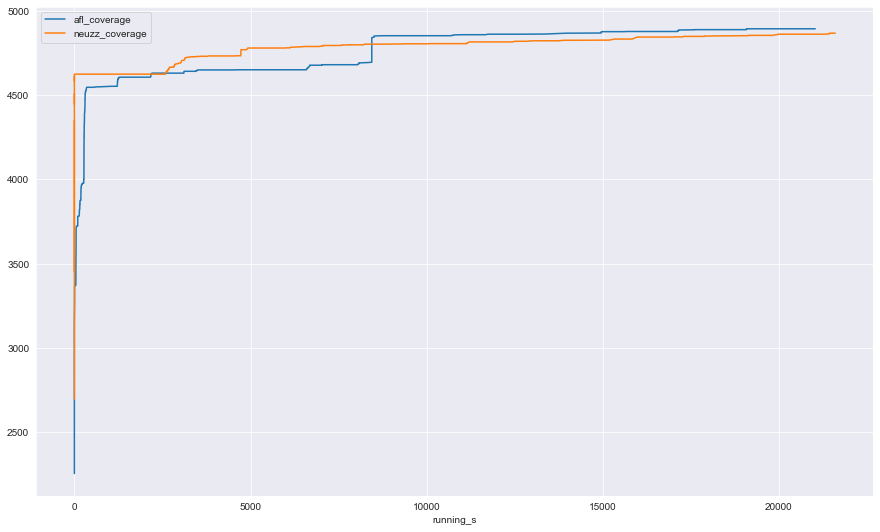

In [55]:
fig, ax = plt.subplots(figsize=(15,9))
fig = df_fuzz.plot(ax=ax)
#plt.margins(x=0)
ax.autoscale(tight=False) 
#fig.show()
#plt.show()
plt.savefig('./mupdf.png')
#df_fuzz.plot(figsize=200)

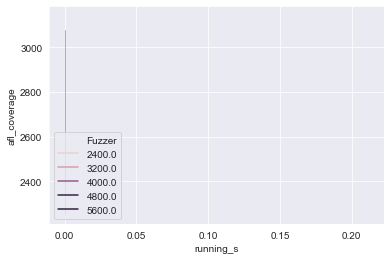

In [20]:
fig, ax = plt.subplots()

sb.set_style("darkgrid")
fig = sb.lineplot(x="running_s", dashes=False, y="afl_coverage",  markers=["o", "o"], data=df_fuzz)

legend = ax.legend()
legend.texts[0].set_text("Fuzzer")

plt.show()

In [ ]:
df = df.pivot(index='x', columns='color', values='y')

df.plot()